In [1]:
%load_ext autoreload
%autoreload 2
import torch
import copy
import numpy as np
import matplotlib.pyplot as plt

from src.models.training.train import TrainModule
from src.loop_calling.dataset.loop_dataset import LoopDataset
from src.utils import predict_matrix, plot_and_save_matrices, load_bigwig_signal
from src.ledidi.edit_tasks import evaluate_asym_to_sym
from src.ledidi.utils import report_nt_changes
from src.ledidi.utils import plot_multi_site_attributions

/cluster/work/boeva/shoenig/conda/envs/chiron/lib/python3.10/site-packages/lightning_fabric/__init__.py:29: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)


### Load in model and dataset

In [2]:
%%capture
CKPT="../data/chiron-model.ckpt"
model = TrainModule.load_from_checkpoint(CKPT)
model.eval()
model.to("cuda")

In [3]:
dataset = LoopDataset(
        regions_file_path="../data/extruding_loops.csv",
        cool_file_path="../data/A673_WT_CTCF_5000.cool",
        fasta_dir="../data/chromosomes",
        genomic_feature_path=None,
        mode="test",
        val_chroms=[],
        test_chroms=["chr2", "chr6", "chr19"],
        use_pretrained_backbone=True
    )

In [4]:
elem = dataset[646]
pred = predict_matrix(elem, model, 'cuda')

In [5]:
elem["idx"] = 646

### Run edit framework, depending on chosen threshold, more or fewer edits get selected

In [11]:
evaluate_asym_to_sym(elem, model, pruning_threshold=0.2, device="cuda", stripe="X", run_dir="ex1")

[STRIPE] diff=1.012, dyn_thresh=0.569, loss=19.569
iter=I	input_loss=0.0	output_loss=19.57	total_loss=19.57	time=0.0
iter=100	input_loss=1.377e+03	output_loss= 0.0	total_loss=27.54	time=39.85
iter=200	input_loss=779.0	output_loss= 0.0	total_loss=15.58	time=40.0
iter=300	input_loss=218.0	output_loss= 0.0	total_loss=4.36	time=39.99
iter=400	input_loss=187.0	output_loss= 0.0	total_loss=3.74	time=40.04
iter=500	input_loss=139.0	output_loss= 0.0	total_loss=2.78	time=40.0
iter=600	input_loss=163.0	output_loss= 0.0	total_loss=3.26	time=40.01
iter=700	input_loss=205.0	output_loss= 0.0	total_loss= 4.1	time=40.01
iter=800	input_loss=214.0	output_loss= 0.0	total_loss=4.28	time=40.0
iter=900	input_loss=121.0	output_loss= 0.0	total_loss=2.42	time=40.0
iter=1000	input_loss=444.0	output_loss=1.518	total_loss=10.4	time=39.97
iter=1100	input_loss=196.0	output_loss= 0.0	total_loss=3.92	time=39.94
iter=1200	input_loss=149.0	output_loss= 0.0	total_loss=2.98	time=39.96
iter=1300	input_loss=285.0	output_los

### Investigate Edits

In [12]:
edited_sequence = torch.load("./ex1/chr2/best_onehot_646.pt")

In [13]:
deep_copy = copy.deepcopy(elem)
deep_copy['sequence'] = edited_sequence
pred_all = predict_matrix(deep_copy, model, 'cuda')

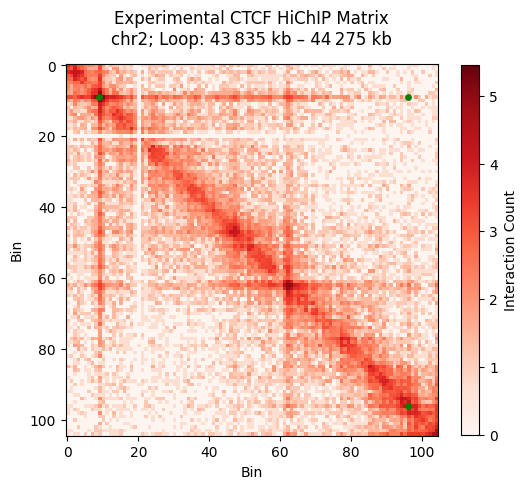

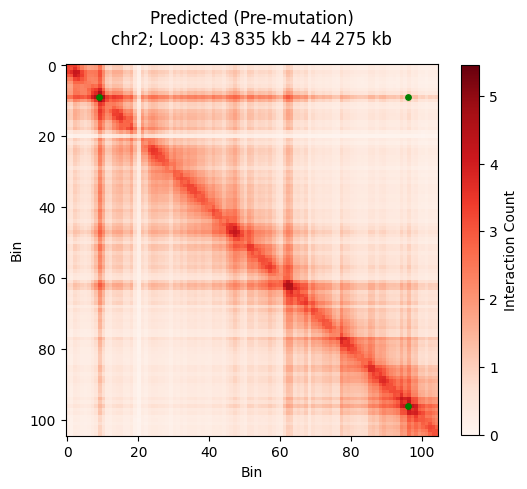

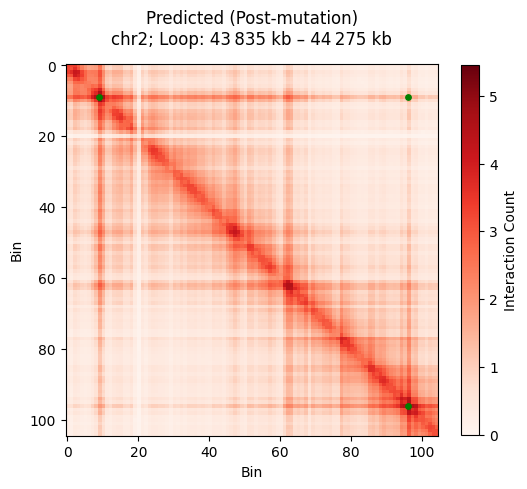

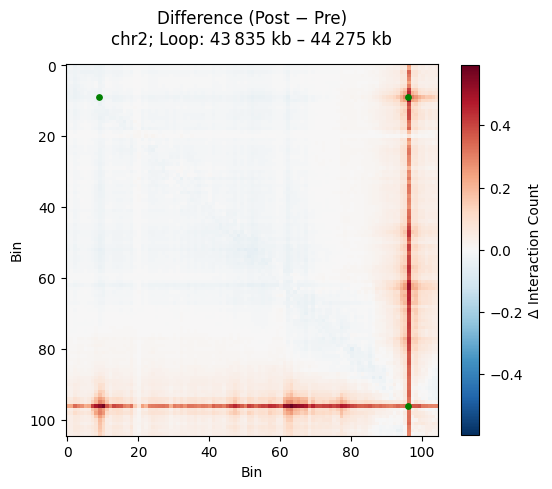

{'exp': '646/Asym_To_Sym_exp.png',
 'pre': '646/Asym_To_Sym_pred_pre.png',
 'post': '646/Asym_To_Sym_pred_post.png',
 'diff': '646/Asym_To_Sym_diff.png'}

In [14]:
%matplotlib inline
plot_and_save_matrices(elem, pred, pred_all, save_dir="646", prefix="Asym_To_Sym", show=True)

### Investigate Edit Location

In [17]:
from src.ledidi.utils import report_nt_changes
edits = report_nt_changes(elem["sequence"], deep_copy["sequence"])

Total sequence-positions with any mismatch: 1
481572: G → C


In [18]:
def plot_ctcf(elem, start, end, mark_start, mark_end):
    chrom = elem["chr"]
    signal = load_bigwig_signal("/cluster/work/boeva/shoenig/ews-ml/data/corigami/raw/A673_WT/genomic_features_data/CTCF/A673_WT_CTCF_coverage_FE.bw", chrom, start, end)
    x = np.arange(start, end)
    x = np.linspace(start, end, num=len(signal), endpoint=False)
    
    fig, ax = plt.subplots(figsize=(5, 3))
    ax.plot(x, signal)
    ax.set_ylabel("Signal")
    ax.set_title("CTCF track")
    ax.set_xlim(start, end)
    
    if (mark_start is not None) and (mark_end is not None):
        hs, he = max(mark_start, start), min(mark_end, end)
        if hs < he:
            ax.axvspan(hs, he, alpha=0.2)
            ax.axvline(hs, linestyle="--", linewidth=0.8)
            ax.axvline(he, linestyle="--", linewidth=0.8)
    
    fig.tight_layout()

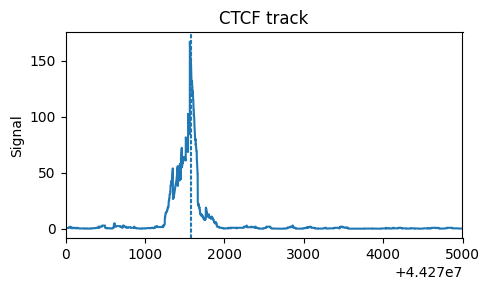

In [19]:
plot_ctcf(elem, elem["region_start"]+480000, elem["region_start"]+485000, elem["region_start"]+481572-1, elem["region_start"]+481572+1)

In [20]:
from src.ledidi.utils import plot_multi_site_attributions

/cluster/work/boeva/shoenig/RECOMB/Chiron3D/src/ledidi/utils.py:214: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  ymin = float(torch.min(torch.min(orig_slice), torch.min(upd_slice)))


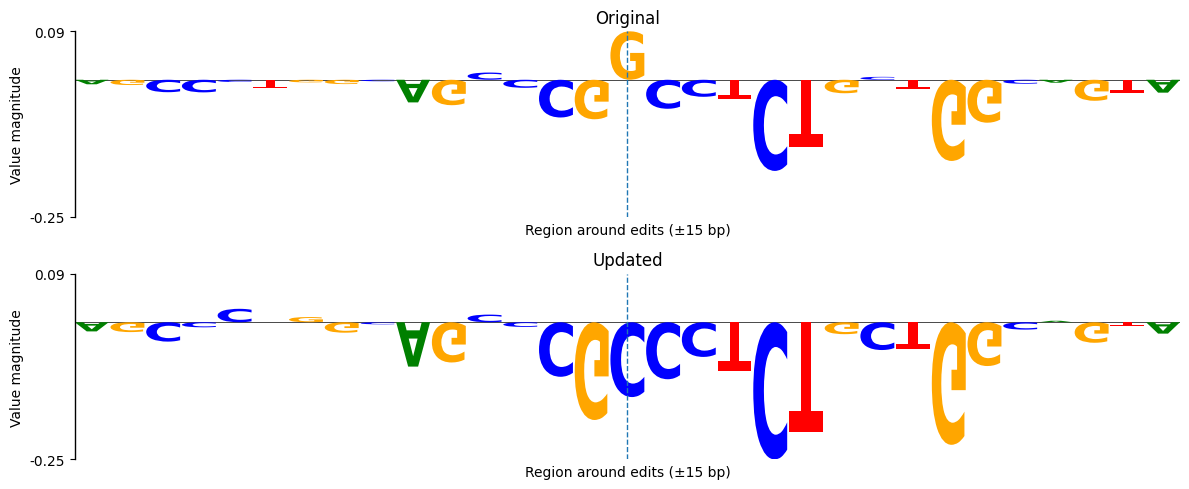

In [21]:
plot_multi_site_attributions(model, elem, edits, window_radius=15)